In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

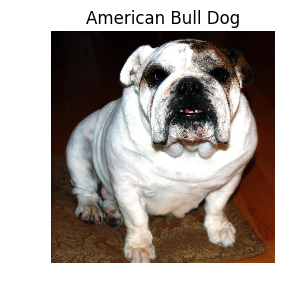

In [5]:
img = load_img('images/2906008778_1baeac7c1b_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Bull Dog')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

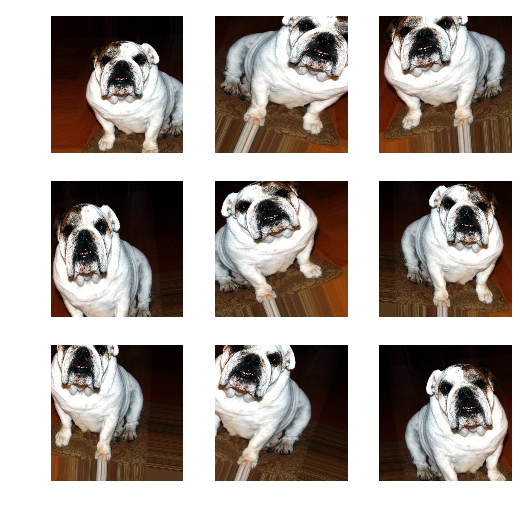

In [7]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

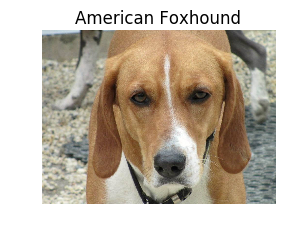

In [8]:
img = load_img('images/8666079478_f15a4bf761_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Foxhound')
plt.show()

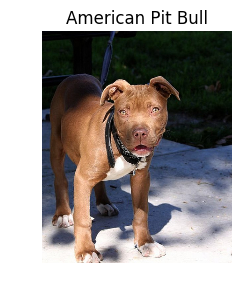

In [9]:
img = load_img('images/3253955567_0a760d07f4.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('American Pit Bull')
plt.show()

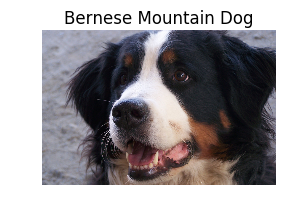

In [10]:
img = load_img('images/515115458_3a2d8e63b0_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Bernese Mountain Dog')
plt.show()

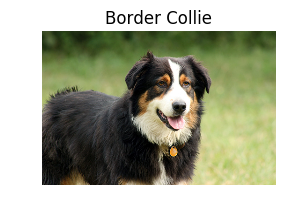

In [11]:
img = load_img('images/367223817_8b489117ba.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Border Collie')
plt.show()

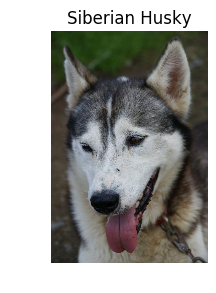

In [12]:
img = load_img('images/1359977110_457925e5f6_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Siberian Husky')
plt.show()

In [13]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 64
nb_classes = len(glob.glob(train_dir + '/*'))

In [14]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

386


In [15]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

110


In [16]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [17]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [18]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 386 images belonging to 6 classes.


In [19]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 110 images belonging to 6 classes.


In [20]:
# set up transfer learning on pre-trained ImageNet Xception model - remove fully connected layer and replace
# with softmax for classifying 10 classes
xcep_model = Xception(weights = 'imagenet', include_top = False)
x = xcep_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = xcep_model.input, output = predictions)

In [21]:
# freeze all layers of the pre-trained model
for layer in xcep_model.layers:
    layer.trainable = False

In [22]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [23]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
386/386 [==============================] - 345s - loss: 1.8515 - acc: 0.5285 - val_loss: 1.4535 - val_acc: 0.5727
Epoch 2/20
386/386 [==============================] - 349s - loss: 0.5991 - acc: 0.8394 - val_loss: 0.3421 - val_acc: 0.8727
Epoch 3/20
386/386 [==============================] - 381s - loss: 0.1760 - acc: 0.9326 - val_loss: 0.7516 - val_acc: 0.8182
Epoch 4/20
386/386 [==============================] - 375s - loss: 0.3662 - acc: 0.8990 - val_loss: 0.4894 - val_acc: 0.8182
Epoch 5/20
386/386 [==============================] - 352s - loss: 0.2910 - acc: 0.9119 - val_loss: 3.8752 - val_acc: 0.2636
Epoch 6/20
386/386 [==============================] - 342s - loss: 1.0426 - acc: 0.8083 - val_loss: 0.2896 - val_acc: 0.9000
Epoch 7/20
386/386 [==============================] - 338s - loss: 0.1613 - acc: 0.9378 - val_loss: 0.3033 - val_acc: 0.9091
Epoch 8/20
386/386 [==============================] - 340s - loss: 0.0838 - acc: 0.9741 - val_loss: 0.4461 - val_acc: 0.8455


In [24]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.922220230103
Test Accuracy: 0.765625


In [25]:
# save transfer learning model for offline prediction purposes
model.save('dogs_xception_model_tl.h5')

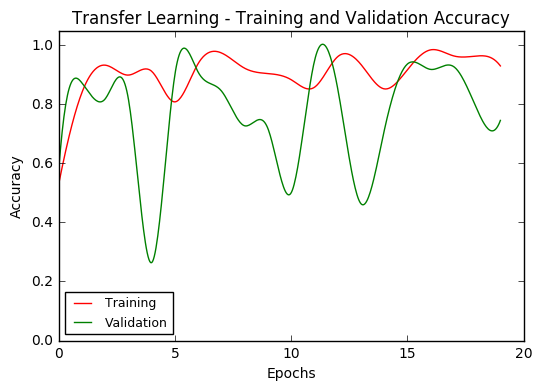

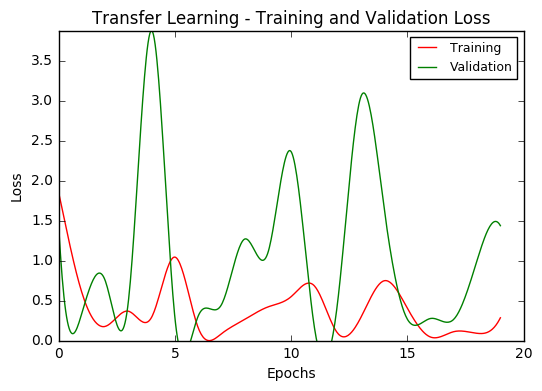

In [26]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [27]:
validate_generator.total_batches_seen

251

In [28]:
num_images = len(glob.glob("dogs_test/*.jpg"))

In [29]:
predict_files = glob.glob("dogs_test/*.jpg")

In [30]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [31]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [32]:
final = pd.DataFrame()
final["id"] = image_id
final["Dog"] = predictor
final.head(num_images)

,id,Dog
0,american_bull_dog_1045354761_d5ac5e20b1_b.jpg,0
1,american_bull_dog_143736875_1c8a4d0588_b.jpg,0
2,american_bull_dog_16403415514_b0474bbeb0_b.jpg,4
3,american_bull_dog_4292746819_bfca81b32f_b.jpg,2
4,american_bull_dog_505641061_c27716d6c9.jpg,0
5,american_bull_dog_5066391242_3e8329054f_b.jpg,1
6,american_bull_dog_5824779286_dd7082193b_b.jpg,0
7,american_bull_dog_8340050876_b5a6b1703a_b.jpg,0
8,american_foxhound_1086935320_b7d416836c.jpg,1
9,american_foxhound_14768856990_4c4eec8ae6_b.jpg,1


In [33]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [34]:
final["Dog"] = final["Dog"].apply(lambda x: classes[x])
final.head(num_images)

,id,Dog
0,american_bull_dog_1045354761_d5ac5e20b1_b.jpg,american_bull_dog
1,american_bull_dog_143736875_1c8a4d0588_b.jpg,american_bull_dog
2,american_bull_dog_16403415514_b0474bbeb0_b.jpg,border_collie
3,american_bull_dog_4292746819_bfca81b32f_b.jpg,american_pit_bull
4,american_bull_dog_505641061_c27716d6c9.jpg,american_bull_dog
5,american_bull_dog_5066391242_3e8329054f_b.jpg,american_foxhound
6,american_bull_dog_5824779286_dd7082193b_b.jpg,american_bull_dog
7,american_bull_dog_8340050876_b5a6b1703a_b.jpg,american_bull_dog
8,american_foxhound_1086935320_b7d416836c.jpg,american_foxhound
9,american_foxhound_14768856990_4c4eec8ae6_b.jpg,american_foxhound


In [35]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 convolution2d_1
13 block2_pool
14 batchnormalization_1
15 merge_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 convolution2d_2
23 block3_pool
24 batchnormalization_2
25 merge_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 convolution2d_3
33 block4_pool
34 batchnormalization_3
35 merge_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 merge_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_se

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [37]:
# Step 1 - Set up fine tuning on pre-trained ImageNet Xception model - freeze lower 94 layers only
for layer in model.layers[:94]:
    layer.trainable = False
for layer in model.layers[94:]:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
386/386 [==============================] - 482s - loss: 1.3583 - acc: 0.7694 - val_loss: 1.4826 - val_acc: 0.7727
Epoch 2/20
386/386 [==============================] - 475s - loss: 1.3218 - acc: 0.7746 - val_loss: 0.8979 - val_acc: 0.8091
Epoch 3/20
386/386 [==============================] - 476s - loss: 0.9598 - acc: 0.8264 - val_loss: 1.1150 - val_acc: 0.8182
Epoch 4/20
386/386 [==============================] - 475s - loss: 0.7195 - acc: 0.8575 - val_loss: 0.7187 - val_acc: 0.8636
Epoch 5/20
386/386 [==============================] - 484s - loss: 0.4969 - acc: 0.8886 - val_loss: 0.5702 - val_acc: 0.8636
Epoch 6/20
386/386 [==============================] - 482s - loss: 0.2994 - acc: 0.9145 - val_loss: 0.5608 - val_acc: 0.9000
Epoch 7/20
386/386 [==============================] - 474s - loss: 0.2910 - acc: 0.9197 - val_loss: 0.4840 - val_acc: 0.9091
Epoch 8/20
386/386 [==============================] - 476s - loss: 0.2338 - acc: 0.9378 - val_loss: 0.4853 - val_acc: 0.8727


In [38]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0383108071983
Test Accuracy: 0.978260874748


In [39]:
# save fine-tuning model for offline prediction purposes
model.save('dogs_xception_model_ft.h5')

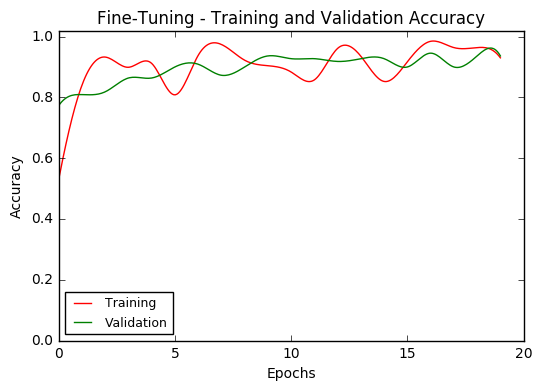

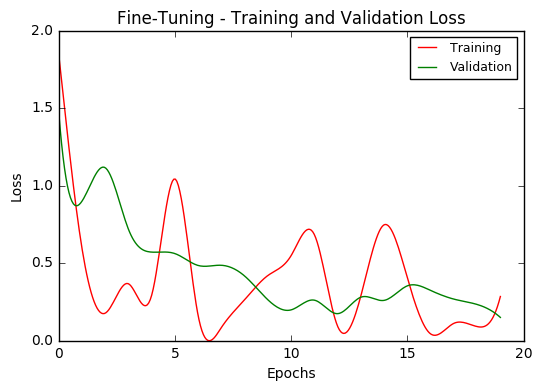

In [49]:
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.show()

In [41]:
validate_generator.total_batches_seen

499

In [42]:
# predict unseen images
predict_files = glob.glob("dogs_test/*.jpg")

In [43]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [44]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [45]:
final = pd.DataFrame()
final["id"] = image_id
final["Dog"] = predictor 
final.head(num_images)

,id,Dog
0,american_bull_dog_1045354761_d5ac5e20b1_b.jpg,0
1,american_bull_dog_143736875_1c8a4d0588_b.jpg,0
2,american_bull_dog_16403415514_b0474bbeb0_b.jpg,0
3,american_bull_dog_4292746819_bfca81b32f_b.jpg,2
4,american_bull_dog_505641061_c27716d6c9.jpg,0
5,american_bull_dog_5066391242_3e8329054f_b.jpg,1
6,american_bull_dog_5824779286_dd7082193b_b.jpg,0
7,american_bull_dog_8340050876_b5a6b1703a_b.jpg,0
8,american_foxhound_1086935320_b7d416836c.jpg,1
9,american_foxhound_14768856990_4c4eec8ae6_b.jpg,1


In [46]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [47]:
final["Dog"] = final["Dog"].apply(lambda x: classes[x])
final.head(num_images)

,id,Dog
0,american_bull_dog_1045354761_d5ac5e20b1_b.jpg,american_bull_dog
1,american_bull_dog_143736875_1c8a4d0588_b.jpg,american_bull_dog
2,american_bull_dog_16403415514_b0474bbeb0_b.jpg,american_bull_dog
3,american_bull_dog_4292746819_bfca81b32f_b.jpg,american_pit_bull
4,american_bull_dog_505641061_c27716d6c9.jpg,american_bull_dog
5,american_bull_dog_5066391242_3e8329054f_b.jpg,american_foxhound
6,american_bull_dog_5824779286_dd7082193b_b.jpg,american_bull_dog
7,american_bull_dog_8340050876_b5a6b1703a_b.jpg,american_bull_dog
8,american_foxhound_1086935320_b7d416836c.jpg,american_foxhound
9,american_foxhound_14768856990_4c4eec8ae6_b.jpg,american_foxhound
